In [1]:
import pykep as pk
import numpy as np
import json
import pickle as pkl
import sys, os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
import cascade as csc
from copy import deepcopy
from tqdm.notebook import tqdm
import heyoka as hy

# 1 - We import data  results of simulation

In [3]:
# This is the old satcat format (contains the operational status)
satcat_legacy = pk.util.read_satcat("../../data/satcat.txt")
# These contain the simulation setup data
with open("../../data/debris_simulation_ic.pk", "rb") as file:
    _,_,_,_,satcat,debris = pkl.load(file)

In [4]:
collision_log_l = []
decay_log_l = []
for dir_name in os.listdir("./"):
    if dir_name[:3] == "out":
        collision_log_l.append(dir_name+"/collision_log.txt")
        decay_log_l.append(dir_name+"/decay_log.txt")

# Here we look into the collision log

In [5]:
def analyze_logs(collision_log, decay_log, verbose = False):
    # To define an average density, we consider the known data for Starlink
    starlinkmass=240
    starlinksize=2. # (this is from our collisional secion modelling)
    # ... and define an average density
    avg_density = starlinkmass / (4/3*np.pi*(starlinksize/2)**3)
    # We loop in the collision log and explore the collision type
    coll_epochs = []
    coll_type = []
    name1 = []
    name2 = []
    unavoidable = []
    total = collision_log.shape[0]
    decayed = decay_log.shape[0]
    for i,entry in enumerate(collision_log):
        if verbose:
            print(f"Years elapsed: {entry[0] / 365.25 : .2f}")
        coll_epochs.append(entry[0] / 365.25)
        # We extract the two satellite ids
        id1 = int(entry[1])
        id2 = int(entry[2])
        r1 = entry[3:6]
        v1 = entry[6:9]
        r2 = entry[9:12]
        v2 = entry[12:15]

        # We compute their masses from our average density and their collision radius
        M1 = debris[id1].collision_radius**3*np.pi*4/3 * avg_density
        M2 = debris[id2].collision_radius**3*np.pi*4/3 * avg_density
        # We compute the event type (NASA breakup model)
        Mtarget = max(M1,M2)
        Mprojectile = min(M1,M2)
        vrel = np.linalg.norm(v1-v2)
        E_value = 0.5*Mprojectile*vrel**2/Mtarget/1000
        if E_value > 40:
            f_type = "Fragmentation"
        if E_value < 40:
            f_type = "Collision"
        coll_type.append(f_type)
        # We log stuff on screen
        if verbose:
            print(satcat[id1]["OBJECT_NAME"] + f", {debris[id1].collision_radius: .2f} m")
            print(satcat[id2]["OBJECT_NAME"] + f", {debris[id2].collision_radius: .2f} m")
            name1.append(satcat[id1]["OBJECT_NAME"])
            name2.append(satcat[id2]["OBJECT_NAME"])

            print(f"Relative velocity: {vrel/1000:.2f} km/sec")
            print(f"{f_type}: {E_value:.4f} J/g", end='')
            # If at least one of the satellite is operational we mark the collision as avoided (assumes CAS)
        id1 = satcat[id1]["OBJECT_ID"].strip()
        id2 = satcat[id2]["OBJECT_ID"].strip()
        # We try to look for it in satcat
        try:
            status1 = satcat_legacy[id1].operationstatus
        except:
            status1="-"
        try:
            status2 = satcat_legacy[id2].operationstatus
        except:
            status1="-"
        if status1=="+" or status2=="+":
            if verbose:
                print(" - Avoided", end='')
        else:
            unavoidable.append(i)
        if verbose:
            print("\n")
    return total, decayed, unavoidable, coll_epochs

In [6]:
avgc = 0
avgd = 0
avgu = 0
for coll, decay in zip(collision_log_l, decay_log_l):
    try:
        collision_log = np.loadtxt(coll, delimiter=",")
        decay_log = np.loadtxt(decay, delimiter=",")
    except: 
        pass
    total, decayed, unavoidable, _ = analyze_logs(collision_log, decay_log, False)
    if total > 10:
        print(total, decayed, len(unavoidable))
        avgc+=total
        avgd+=decayed
        avgu+=len(unavoidable)
print("\nAverages:")    
print(f"n_coll: {avgc/10}, n_decayed: {avgd/10}, n_unavoidable:{avgu/10}")

33 1140 1
26 1141 6
35 1138 7
40 1137 7
35 1137 11
26 1141 3
27 1136 4
38 1143 10
23 1139 5
26 1139 3

Averages:
n_coll: 30.9, n_decayed: 1139.1, n_unavoidable:5.7


# We produce some plots on the satellites

In [7]:
collision_log = np.loadtxt(collision_log_l[1], delimiter=",")
total, decayed, unavoidable, coll_epochs = analyze_logs(collision_log, decay_log, False)

<IPython.core.display.Javascript object>


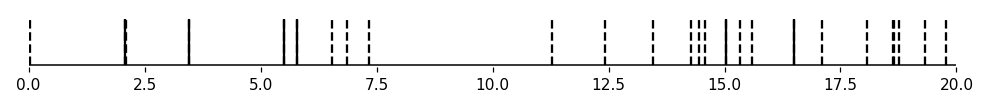

In [8]:
import matplotlib.lines as lin
fig = plt.figure(figsize = (9,1))
ax = plt.axes(frameon=False)
plt.vlines(coll_epochs, 0, 1, linestyles='dashed', color='k')
plt.vlines(np.array(coll_epochs)[unavoidable], 0, 1, color='k')
ax.get_xaxis().tick_bottom()
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim(0,20)
ax.add_artist(lin.Line2D((0, 20), (0, 0), color='black', linewidth=1))
plt.tight_layout()
plt.savefig("coll_freq.png", dpi=300)